# Descripción

**Objetivo:** Estimatar ATE e ITE a partir de los confounders y las mejores features para predecir P(Y|T,X)


# Dependencies

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

from config import TREATMENT, OUTCOME, SEED
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.base import clone
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier, CatBoostRegressor

from utils.potential_outcomes import (
    get_metrics,
    individual_dose_response_curve,
    average_dose_response_curve,
    get_ci_estimates,
)

from utils.preprocessing import create_stratification_split_col
from utils.linear_regression import build_sm_regression_formula
from modules.generealized_propensity_score import GPS
from modules.evaluation import cumgain_auc, cumgain_curve, plot_cumgain

import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.precision", 3)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Environment variables

In [2]:
CONTROLS_PATH = "data/controls.txt"
OUTCOME_CAUSES_PATH = "data/outcome_causes.txt"

In [3]:
plot_ates = {
    "logistic_reg": "orange",
    "s_learner": "darkblue",
    "augmented_iptw": "lightblue",
}

In [4]:
np.random.seed(SEED)

# Utils

# Data

In [5]:
with open(CONTROLS_PATH) as f:
    controls = f.read().split("\n")
controls = [c for c in controls if c != ""]
controls

['n_loans',
 'n_cards',
 'loss_given_default',
 'debt_cirbe',
 'default_debt_amount',
 'years_since_default',
 'n_refin']

In [6]:
with open(OUTCOME_CAUSES_PATH) as f:
    outcome_causes = f.read().split("\n")
outcome_causes = [c for c in outcome_causes if c != ""]
outcome_causes

['months_since_first_payment', 'years_history', 'n_accounts']

In [7]:
df_original = pd.read_parquet("data/synthetic_data.parquet")
df = df_original[controls + outcome_causes + [TREATMENT, OUTCOME]]
train_propagated = pd.read_parquet("data/synthetic_train_data_propagated.parquet")

# Split

In [8]:
strat_feature = create_stratification_split_col(df, TREATMENT, OUTCOME)
train, test = train_test_split(
    df, 
    test_size=0.2, 
    random_state=SEED, 
    stratify=strat_feature,
)

X_train_propagated, y_train_propagated = (
    train_propagated[controls + outcome_causes +[TREATMENT]],
    train_propagated[[OUTCOME]],
)

X_train, y_train = (
    train.drop(columns=[OUTCOME]).copy(),
    train[[OUTCOME]],
)
X_test, y_test = (
    test[X_train.columns],
    test[[OUTCOME]],
)
print(X_train_propagated.shape, X_train.shape, X_test.shape)

(14387, 11) (12000, 11) (3000, 11)


# Estimation

In [9]:
step = 2
bin_edges = np.arange(0, 100+step, step)
intervals_plot = [(bin_edges[i], bin_edges[i+1]) for i in range(len(bin_edges)-1)]

In [10]:
monotone_constraints_list = []

for f in controls + outcome_causes + [TREATMENT]:
    if f != TREATMENT:
        monotone_constraints_list.append(0)
    else:
        monotone_constraints_list.append(1)

## Logistic regression

In [11]:
binned_outcome_causes = [c  + '_bins' for c in outcome_causes]
for feature in outcome_causes:
    bins = pd.qcut(train_propagated[feature], q=5, retbins=True, duplicates='drop')[1]
    max_val_train = train_propagated[feature].max() 
    max_val_int = test[feature].max() 
    bins[-1] = max_val_train if max_val_train > max_val_int else max_val_int
    min_val_train = train_propagated[feature].min()
    min_val_int = test[feature].min()
    bins[0] = min_val_train if min_val_train < min_val_int else min_val_int

    # Apply these bins to both datasets using pd.cut()
    train[feature + '_bins'] = pd.cut(train[feature], bins=bins, include_lowest=True)
    test[feature + '_bins'] = pd.cut(test[feature], bins=bins, include_lowest=True)
    train_propagated[feature + '_bins'] = pd.cut(train_propagated[feature], bins=bins, include_lowest=True)

features_regression = controls + outcome_causes + binned_outcome_causes + [TREATMENT]

In [12]:
regression_formula_str = build_sm_regression_formula(
    outcome=OUTCOME,
    treatment=TREATMENT,
    confounders=controls+outcome_causes,
    interactive_features=binned_outcome_causes
)

print("Constructed formula:")
print(regression_formula_str)

Constructed formula:
debt_repayment_flag ~ perc_debt_loss + n_loans + n_cards + loss_given_default + debt_cirbe + default_debt_amount + years_since_default + n_refin + months_since_first_payment + years_history + n_accounts + months_since_first_payment_bins:perc_debt_loss + years_history_bins:perc_debt_loss + n_accounts_bins:perc_debt_loss


In [13]:
# weights = train_propagated["sample_weights"]
model_logit = smf.logit(
    formula=regression_formula_str,
    data=train_propagated
).fit(weights=None)

print(model_logit.summary())

Optimization terminated successfully.
         Current function value: 0.525415
         Iterations 7
                            Logit Regression Results                           
Dep. Variable:     debt_repayment_flag   No. Observations:                14387
Model:                           Logit   Df Residuals:                    14366
Method:                            MLE   Df Model:                           20
Date:                 Mon, 10 Feb 2025   Pseudo R-squ.:                  0.2418
Time:                         06:57:49   Log-Likelihood:                -7559.1
converged:                        True   LL-Null:                       -9969.8
Covariance Type:             nonrobust   LLR p-value:                     0.000
                                                                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [14]:
summary_df_log = pd.DataFrame({
    'coef': model_logit.params,
    'std_err': model_logit.bse,
    'z_value': model_logit.tvalues,  # In logistic regression, these are z-values
    'p_value': model_logit.pvalues,
    'odds_ratio': np.exp(model_logit.params),  # Convert coefficients to odds ratios
    'odds_ratio_conf_lower': np.exp(model_logit.conf_int()[0]),
    'odds_ratio_conf_upper': np.exp(model_logit.conf_int()[1])
})

display(summary_df_log)

,coef,std_err,z_value,p_value,odds_ratio,odds_ratio_conf_lower,odds_ratio_conf_upper
Intercept,-0.06839,0.17053,-0.40103,0.68840,0.93390,0.66857,1.30453
perc_debt_loss,0.04378,0.00203,21.59522,0.00000,1.04476,1.04061,1.04892
"months_since_first_payment_bins[T.Interval(8.468, 20.293, closed='right')]:perc_debt_loss",0.00184,0.00115,1.59412,0.11091,1.00184,0.99958,1.00410
"months_since_first_payment_bins[T.Interval(20.293, 36.158, closed='right')]:perc_debt_loss",0.00259,0.00121,2.14424,0.03201,1.00259,1.00022,1.00497
"months_since_first_payment_bins[T.Interval(36.158, 63.152, closed='right')]:perc_debt_loss",0.00220,0.00133,1.65361,0.09821,1.00221,0.99959,1.00483
"months_since_first_payment_bins[T.Interval(63.152, 355.304, closed='right')]:perc_debt_loss",0.00325,0.00189,1.72078,0.08529,1.00325,0.99955,1.00697
"years_history_bins[T.Interval(11.591, 16.095, closed='right')]:perc_debt_loss",0.00203,0.00121,1.66872,0.09517,1.00203,0.99965,1.00442
"years_history_bins[T.Interval(16.095, 20.695, closed='right')]:perc_debt_loss",0.00324,0.00135,2.39971,0.01641,1.00324,1.00059,1.00590
"years_history_bins[T.Interval(20.695, 27.245, closed='right')]:perc_debt_loss",0.00424,0.00159,2.66629,0.00767,1.00425,1.00113,1.00739
"years_history_bins[T.Interval(27.245, 84.133, closed='right')]:perc_debt_loss",0.00366,0.00218,1.67698,0.09355,1.00366,0.99938,1.00796


In [15]:
print("Train")
get_metrics(train, y_train, model_logit, task="classification", model_package="statsmodels")
print("")

print("Test")
get_metrics(test, y_test, model_logit, task="classification", model_package="statsmodels")
print("")

Train
AUC: 0.74
Accuracy: 0.65
F1: 0.70
recall: 0.85
precision: 0.60

Test
AUC: 0.74
Accuracy: 0.65
F1: 0.71
recall: 0.86
precision: 0.60



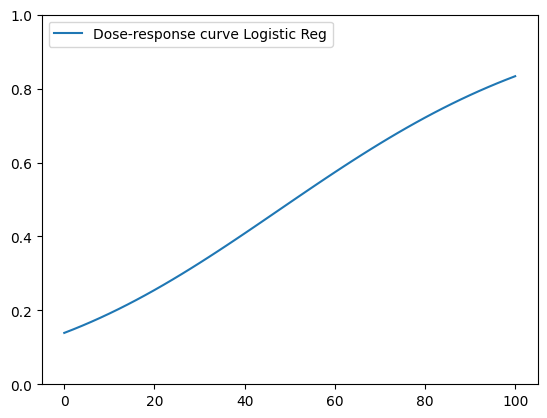

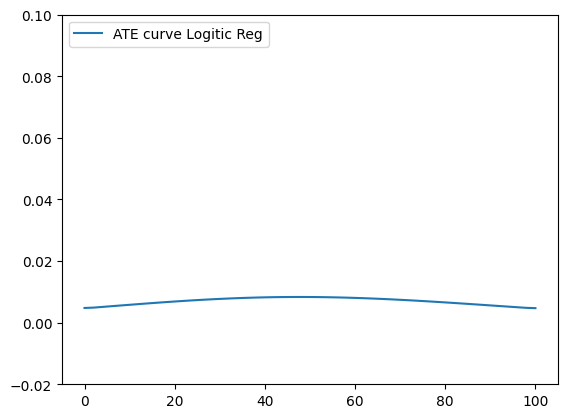

In [16]:
features_ate = [c for c in test if c != OUTCOME]

dose_response_data = average_dose_response_curve(
    df_eval=test,
    treatment_interventions=bin_edges,
    predictive_model=model_logit, 
    modelling_features=features_regression, 
    feature_counterfactual=TREATMENT, 
    model_package="statsmodels",
    task="classification"
)
ate_curve_data = np.gradient(dose_response_data, bin_edges)

plt.plot(bin_edges, dose_response_data, label="Dose-response curve Logistic Reg")
plt.legend(loc="upper left")
plt.ylim(0, 1)
plt.show()


plt.plot(bin_edges, ate_curve_data, label="ATE curve Logitic Reg")
plt.legend(loc="upper left")
plt.ylim(-0.02, 0.1)
plt.show()

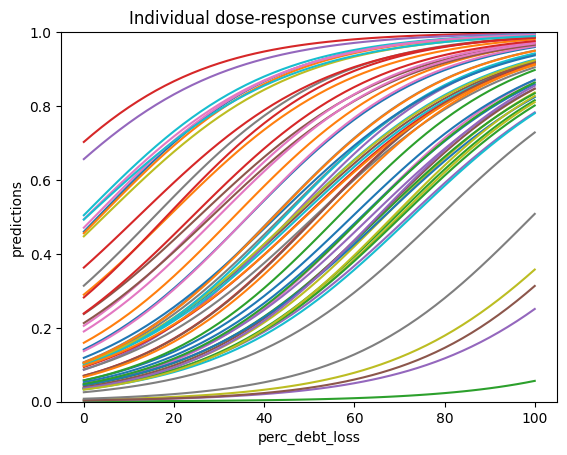

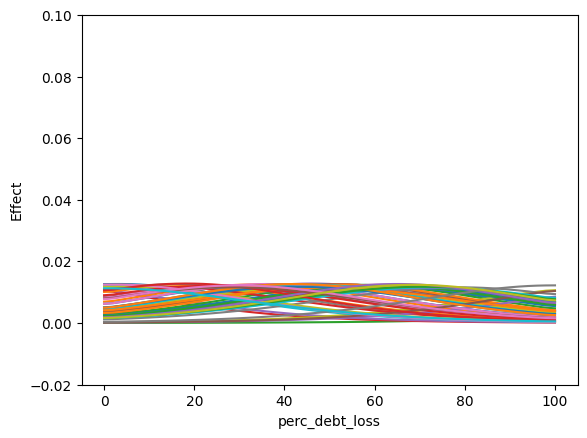

In [17]:
dose_response_data = individual_dose_response_curve(
    df_eval=test,
    treatment_interventions=bin_edges,
    predictive_model=model_logit, 
    modelling_features=features_regression, 
    feature_counterfactual=TREATMENT, 
    model_package="statsmodels",
    task="classification"
)
for i, line in enumerate(dose_response_data):
    if i % 50 == 0:
        ax = plt.plot(bin_edges, line, label=f'Line {i+1}')
plt.title("Individual dose-response curves estimation")
plt.xlabel(TREATMENT)
plt.ylabel("predictions")
plt.ylim(0, 1)
plt.show()


for i, line in enumerate(dose_response_data):
    if i % 50 == 0:
        ite_curve_data = np.gradient(line, bin_edges)
        ax = plt.plot(bin_edges, ite_curve_data, label=f'Line {i+1}')
plt.xlabel(TREATMENT)
plt.ylabel("Effect")
plt.ylim(-0.02, 0.1)
plt.show()

**Compute cumgain curves**

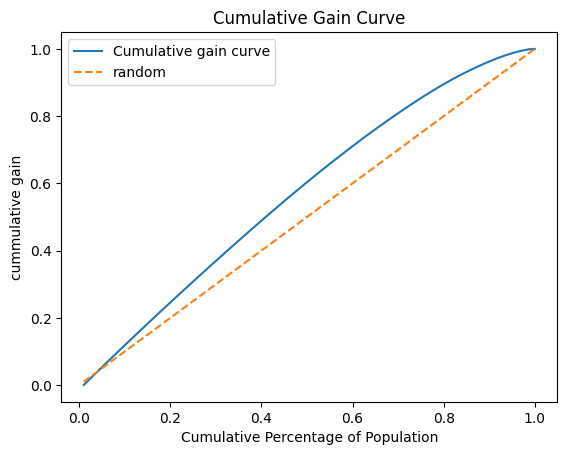

AUC for Logit: 0.5708389644542016


In [18]:
DELTA = 1
test_increment = test.copy()
test_increment['p_repayment'] = model_logit.predict(test_increment)
test_increment['perc_debt_loss'] += DELTA
test_increment['ite'] = (model_logit.predict(test_increment) - test_increment['p_repayment']) / DELTA

test_increment['ite'] = test_increment['ite'].fillna(0) #ñapa

plot_cumgain(*cumgain_curve(test_increment))
print(f'AUC for Logit: {cumgain_auc(*cumgain_curve(test_increment))}')

## S-learner

In [19]:
init_params = {
    "n_estimators": 500,
    "depth": None,
    "min_data_in_leaf": round(X_train_propagated.shape[0]*0.05),
    "learning_rate": 0.01,
    "subsample": 1,
    "rsm": 1,
    "objective": "Logloss",
    "silent": True,
    "l2_leaf_reg": 0,
    "random_seed": SEED,
}
init_params["monotone_constraints"] = monotone_constraints_list
s_learner = CatBoostClassifier(**init_params)
s_learner.fit(
    X_train_propagated[controls + outcome_causes + [TREATMENT]].copy().to_numpy(), 
    y_train_propagated.to_numpy(),
    #sample_weight=X_train_propagated["sample_weights"].to_numpy(),
)

print("Train")
get_metrics(X_train[controls + outcome_causes +[TREATMENT]], y_train, s_learner)
print("")

print("Test")
get_metrics(X_test[controls + outcome_causes + [TREATMENT]], y_test, s_learner)
print("")

Train
AUC: 0.80
Accuracy: 0.70
F1: 0.73
recall: 0.85
precision: 0.65

Test
AUC: 0.74
Accuracy: 0.67
F1: 0.71
recall: 0.83
precision: 0.62



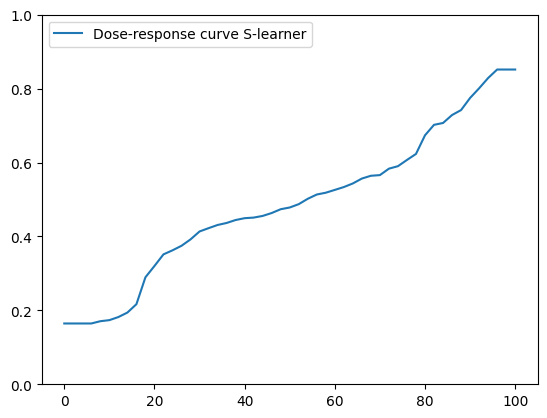

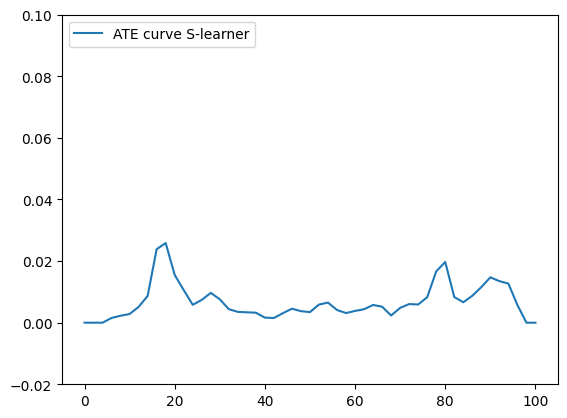

In [20]:
features_ate = [c for c in df if c != OUTCOME]

dose_response_data = average_dose_response_curve(
    df_eval=test,
    treatment_interventions=bin_edges,
    predictive_model=s_learner, 
    modelling_features=features_ate, 
    feature_counterfactual=TREATMENT, 
    model_package="sklearn",
    task="classification"
)
ate_curve_data = np.gradient(dose_response_data, bin_edges)

plt.plot(bin_edges, dose_response_data, label="Dose-response curve S-learner")
plt.legend(loc="upper left")
plt.ylim(0, 1)
plt.show()


plt.plot(bin_edges, ate_curve_data, label="ATE curve S-learner")
plt.legend(loc="upper left")
plt.ylim(-0.02, 0.1)
plt.show()

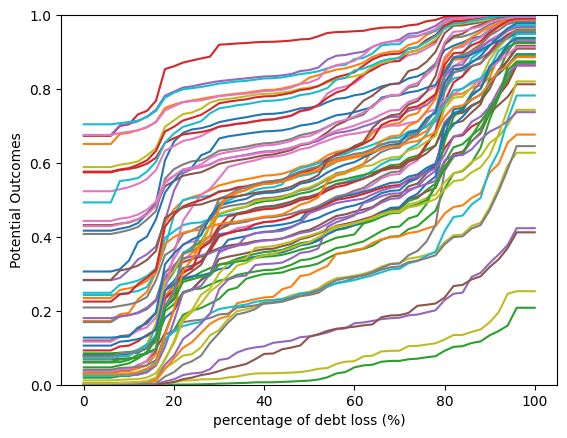

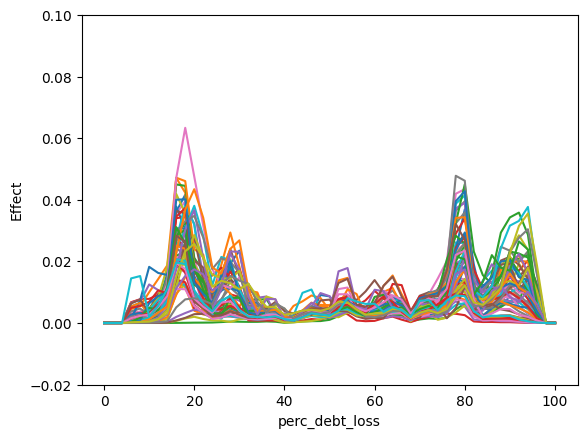

In [21]:
dose_response_data = individual_dose_response_curve(
    df_eval=test,
    treatment_interventions=bin_edges,
    predictive_model=s_learner, 
    modelling_features=X_train.columns, 
    feature_counterfactual=TREATMENT, 
    model_package="sklearn",
    task="classification"
)
for i, line in enumerate(dose_response_data):
    if i % 50 == 0:
        ax = plt.plot(bin_edges, line, label=f'Line {i+1}')
plt.xlabel("percentage of debt loss (%)")
plt.ylabel("Potential Outcomes")
plt.ylim(0, 1)
plt.show()


for i, line in enumerate(dose_response_data):
    if i % 50 == 0:
        ite_curve_data = np.gradient(line, bin_edges)
        ax = plt.plot(bin_edges, ite_curve_data, label=f'Line {i+1}')
plt.xlabel(TREATMENT)
plt.ylabel("Effect")
plt.ylim(-0.02, 0.1)
plt.show()

**Compute cumgain curves**

In [22]:
dose_response_data = individual_dose_response_curve(
    df_eval=test,
    treatment_interventions=bin_edges,
    predictive_model=s_learner, 
    modelling_features=X_train.columns, 
    feature_counterfactual=TREATMENT, 
    model_package="sklearn",
    task="classification"
)

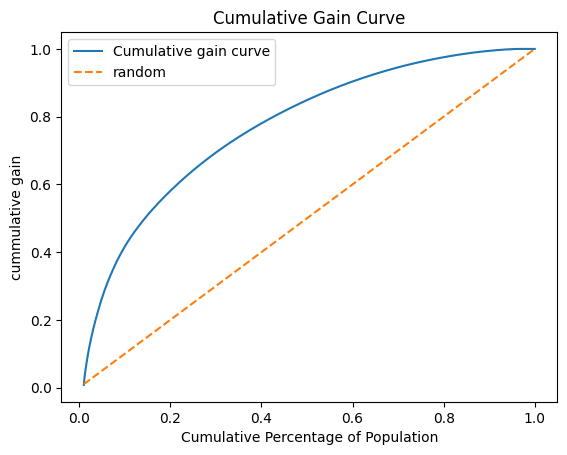

AUC for Logit: 0.7688212169938923


In [23]:
DELTA = 1
test_increment = X_test.copy()
test_increment['p_repayment'] = s_learner.predict_proba(test_increment)[:, 1]
test_increment['perc_debt_loss'] += DELTA
test_increment['ite'] = (s_learner.predict_proba(test_increment)[:, 1] - test_increment['p_repayment']) / DELTA

plot_cumgain(*cumgain_curve(test_increment))
print(f'AUC for Logit: {cumgain_auc(*cumgain_curve(test_increment))}')

## Augmented IPTW

In [24]:
# Propensity Model
init_propensity_params = {
    "n_estimators": 200,
    "depth": None,
    "min_data_in_leaf": round(X_train_propagated.shape[0]*(2/3)*0.01),
    "learning_rate": 0.01,
    "subsample": 1,
    "rsm": 1,
    "objective": "RMSE",
    "silent": True,
    "l2_leaf_reg": 1,
    "random_seed": SEED,
}
model_propensity = CatBoostRegressor(**init_propensity_params)

step = 5
bin_edges_contained = np.arange(0, 100+step, step)
bin_edges_contained[0] = -1

weighter = GPS(model=model_propensity, n_folds=3, random_state=SEED)
weights_iptw_da = weighter.compute_weights(
    X_train_propagated[controls], X_train_propagated[[TREATMENT]], bin_edges_contained
)

In [25]:
p99 = np.percentile(weights_iptw_da, 99)
weights_iptw_da = np.minimum(weights_iptw_da, p99)


In [26]:
features_outcome_model = controls + outcome_causes + [TREATMENT]
outcome_model_params = {
    "n_estimators": 500,
    "depth": None,
    "min_data_in_leaf": round(X_train_propagated.shape[0]*(2/3)*0.05),
    "learning_rate": 0.01,
    "subsample": 1,
    "rsm": 1,
    "objective": "Logloss",
    "silent": True,
    "l2_leaf_reg": 0,
    "random_seed": SEED,
}
outcome_model_params["monotone_constraints"] = monotone_constraints_list
outcome_model_aiptw = CatBoostClassifier(**outcome_model_params)
X_train_propagated_copy = X_train_propagated.copy()
X_train_propagated_copy["outcome_model_oos_predictions"] = 0.0

kf = KFold(n_splits=3, shuffle=True, random_state=SEED)
for train_idx, test_idx in kf.split(X_train_propagated):
    X_train_propagated_cv, X_val_propgated_cv = (
        X_train_propagated.iloc[train_idx, :], 
        X_train_propagated.iloc[test_idx, :]
    )
    y_train_propagated_fold = y_train_propagated.iloc[train_idx, :][[OUTCOME]]
    outcome_model_aiptw_fold = clone(outcome_model_aiptw)
    outcome_model_aiptw_fold.fit(X_train_propagated_cv[features_outcome_model], y_train_propagated_fold)

    # Predict on test data
    X_train_propagated_copy.iloc[test_idx, -1] = outcome_model_aiptw_fold.predict_proba(X_val_propgated_cv)[:, 1]

In [27]:
m_hat = X_train_propagated_copy["outcome_model_oos_predictions"].to_numpy().flatten()
pseudo_Y = m_hat + (y_train_propagated.to_numpy().flatten() - m_hat) * weights_iptw_da
train_propagated["pseudo_Y"] = pseudo_Y

train_propagated["pseudo_Y"]


14869    0.94627
9821     0.83734
12710    0.17464
3792     0.24561
6916     0.06853
          ...   
7678    -0.42216
541     -0.09684
1780    -0.27991
2561    -0.02044
11671   -0.04767
Name: pseudo_Y, Length: 14387, dtype: float64

In [28]:
final_model_params = {
    "n_estimators": 500,
    "depth": None,
    "min_data_in_leaf": round(X_train_propagated.shape[0]*(2/3)*0.05),
    "learning_rate": 0.01,
    "subsample": 1,
    "rsm": 1,
    "objective": "RMSE",
    "silent": True,
    "l2_leaf_reg": 0,
    "random_seed": SEED,
}
final_model_params["monotone_constraints"] = monotone_constraints_list
final_model_aiptw = CatBoostRegressor(**final_model_params)

X_train_propagated_copy = X_train_propagated.copy()
X_train_propagated_copy["final_model_oos_predictions"] = 0.0

kf = KFold(n_splits=3, shuffle=True, random_state=SEED)
for train_idx, test_idx in kf.split(X_train_propagated):
    X_train_propagated_cv, X_val_propgated_cv = (
        X_train_propagated.iloc[train_idx, :], 
        X_train_propagated.iloc[test_idx, :]
    )
    pseudo_y_fold = train_propagated.iloc[train_idx, :][["pseudo_Y"]]
    final_model_aiptw_fold = clone(final_model_aiptw)
    final_model_aiptw_fold.fit(X_train_propagated_cv[features_outcome_model], pseudo_y_fold)

    # Predict on test data
    X_train_propagated_copy.iloc[test_idx, -1] = final_model_aiptw_fold.predict(X_val_propgated_cv)

# Refit
final_model_aiptw.set_params(min_data_in_leaf=round(X_train_propagated.shape[0]*0.05))
final_model_aiptw.fit(
    X_train_propagated[features_outcome_model],
    y_train_propagated
)
train_preds = final_model_aiptw.predict(X_train[features_outcome_model])
test_preds = final_model_aiptw.predict(X_test[features_outcome_model])

print("Train")
get_metrics(X_train[features_outcome_model], y_train, final_model_aiptw, model_package="self_aiptw")
print("")

print("Test")
get_metrics(X_test[features_outcome_model], y_test, final_model_aiptw, model_package="self_aiptw")
print("")


Train
AUC: 0.78
Accuracy: 0.69
F1: 0.73
recall: 0.82
precision: 0.65

Test
AUC: 0.74
Accuracy: 0.65
F1: 0.71
recall: 0.87
precision: 0.60



In [29]:
final_model_aiptw_calib = LogisticRegression(solver="lbfgs") 
final_model_aiptw_calib.fit(
    X_train_propagated_copy["final_model_oos_predictions"].to_numpy().reshape(-1, 1), 
    y_train_propagated
)
X_train_copy = X_train.copy()
X_train_copy["final_model_oos_predictions"] = train_preds

X_test_copy = X_test.copy()
X_test_copy["final_model_oos_predictions"] = test_preds

print("Train")
get_metrics(X_train_copy[["final_model_oos_predictions"]], y_train, final_model_aiptw_calib)
print("")

print("Test")
get_metrics(X_test_copy[["final_model_oos_predictions"]], y_test, final_model_aiptw_calib)
print("")

Train
AUC: 0.78
Accuracy: 0.69
F1: 0.73
recall: 0.83
precision: 0.64

Test
AUC: 0.74
Accuracy: 0.65
F1: 0.71
recall: 0.87
precision: 0.60



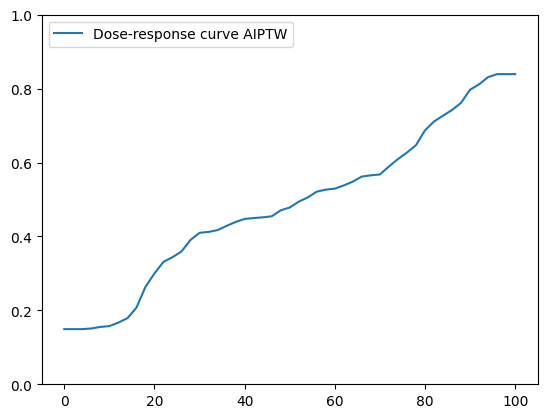

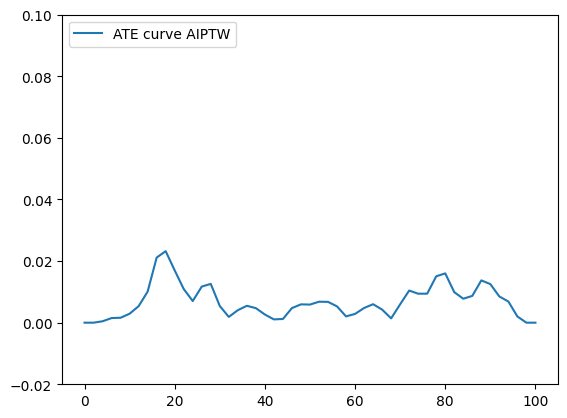

In [30]:
features_ate = [c for c in df if c != OUTCOME]

dose_response_data = average_dose_response_curve(
    df_eval=test,
    treatment_interventions=bin_edges,
    predictive_model=[final_model_aiptw, final_model_aiptw_calib], 
    modelling_features=features_ate, 
    feature_counterfactual=TREATMENT, 
    model_package="self_aiptw_calibrated",
    task="classification"
)
ate_curve_data = np.gradient(dose_response_data, bin_edges)

plt.plot(bin_edges, dose_response_data, label="Dose-response curve AIPTW")
plt.legend(loc="upper left")
plt.ylim(0, 1)
plt.show()


plt.plot(bin_edges, ate_curve_data, label="ATE curve AIPTW")
plt.legend(loc="upper left")
plt.ylim(-0.02, 0.1)
plt.show()

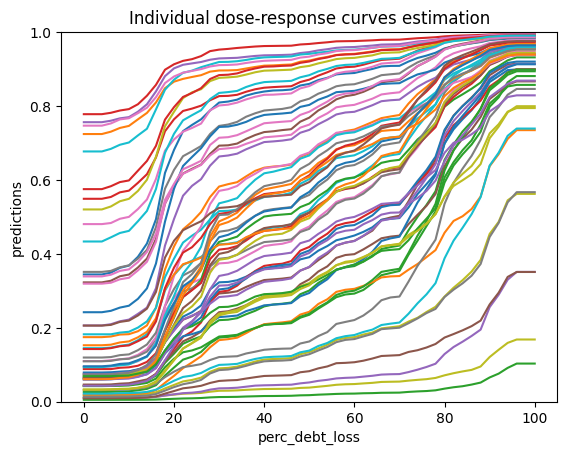

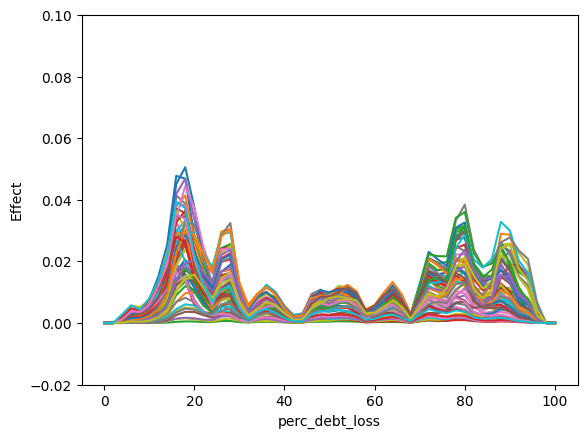

In [31]:
dose_response_data = individual_dose_response_curve(
    df_eval=test,
    treatment_interventions=bin_edges,
    predictive_model=[final_model_aiptw, final_model_aiptw_calib], 
    modelling_features=X_train.columns, 
    feature_counterfactual=TREATMENT, 
    model_package="self_aiptw_calibrated",
    task="classification"
)
for i, line in enumerate(dose_response_data):
    if i % 50 == 0:
        ax = plt.plot(bin_edges, line, label=f'Line {i+1}')
plt.title("Individual dose-response curves estimation")
plt.xlabel(TREATMENT)
plt.ylabel("predictions")
plt.ylim(0, 1)
plt.show()


for i, line in enumerate(dose_response_data):
    if i % 50 == 0:
        ite_curve_data = np.gradient(line, bin_edges)
        ax = plt.plot(bin_edges, ite_curve_data, label=f'Line {i+1}')
plt.xlabel(TREATMENT)
plt.ylabel("Effect")
plt.ylim(-0.02, 0.1)
plt.show()

# Comparison

In [32]:
probs_table = pd.DataFrame(
    columns=[
        TREATMENT,
        "logistic_reg",
        "s_learner",
        "augmented_iptw",
    ]
)
probs_table[TREATMENT] = bin_edges

## Dose-response

In [33]:
features_modelling = controls +  outcome_causes + [TREATMENT]
for treatment_intervention in bin_edges:
    # data
    data_intervention = X_test.copy()
    data_intervention_binned = test.copy()
    data_intervention[TREATMENT] = treatment_intervention
    data_intervention_binned[TREATMENT] = treatment_intervention

    # predict
    predictions_reg = model_logit.predict(
        data_intervention_binned
    )
    predictions_s_learner = s_learner.predict_proba(data_intervention[features_modelling])[
        :, 1
    ]
    data_intervention["final_model_oos_predictions"] = final_model_aiptw.predict(data_intervention[features_modelling])
    predictions_iptw = final_model_aiptw_calib.predict_proba(data_intervention[["final_model_oos_predictions"]])[
        :, 1
    ]

    # P(Y | X, Z)
    probs_table.loc[probs_table[TREATMENT] == treatment_intervention, "logistic_reg"] = np.mean(
        predictions_reg
    )
    probs_table.loc[probs_table[TREATMENT] == treatment_intervention, "s_learner"] = np.mean(
        predictions_s_learner
    )
    probs_table.loc[probs_table[TREATMENT] == treatment_intervention, "augmented_iptw"] = (
        np.mean(predictions_iptw)
    )

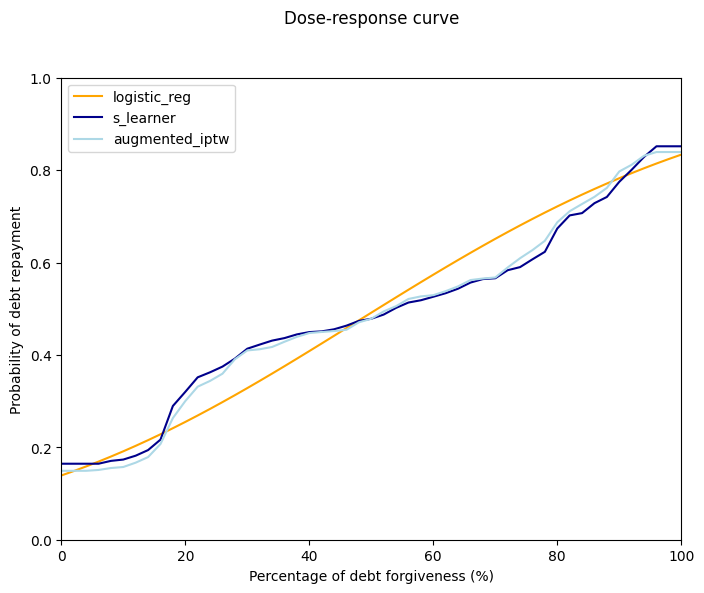

In [34]:
plt.figure(figsize=(8, 6))
for c, color in plot_ates.items():
    plt.plot(bin_edges, probs_table[c], label=c, color=color)
plt.xlabel("Percentage of debt forgiveness (%)")
plt.ylabel("Probability of debt repayment")
plt.title("Dose-response curve", y=1.1, x=0.5)
plt.legend()
plt.ylim(0, 1)
plt.xlim(0, 100)
plt.show()

## Effect

In [35]:
ate_table = probs_table.copy()
for model_ate in plot_ates.keys():
    ate_table["causal_effect_curve_" + model_ate] = np.gradient(probs_table[model_ate], bin_edges)

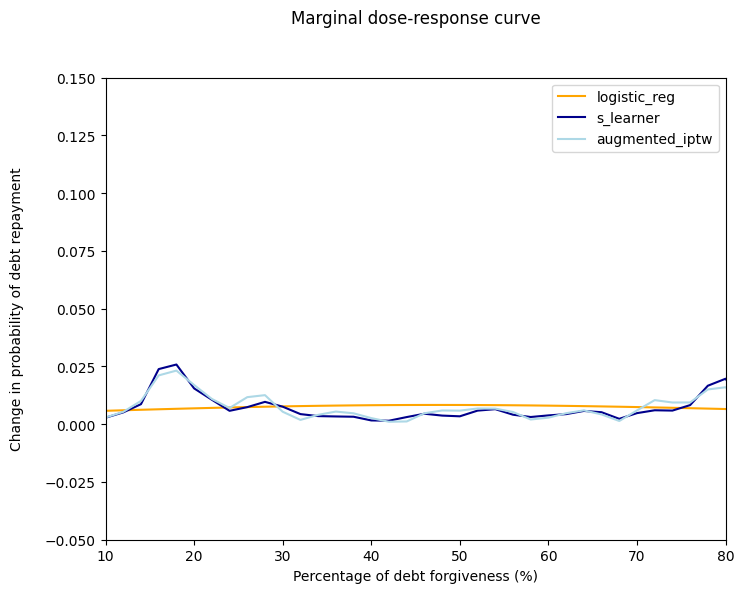

In [36]:
plt.figure(figsize=(8, 6))
for c, color in plot_ates.items():
    plt.plot(bin_edges, ate_table["causal_effect_curve_" + c], label=c, color=color)

plt.xlabel("Percentage of debt forgiveness (%)")
plt.ylabel(
    f"Change in probability of debt repayment",
    labelpad=15,
)
plt.title("Marginal dose-response curve", y=1.1, x=0.5)
plt.legend()
plt.xlim(10, 80)
plt.ylim(-0.05, 0.15)
plt.show()

# Confindence Intervals

In [37]:
est_methods = ["logistic_reg", "s_learner", "aiptw"]
colors = {
    "logistic_reg": "orange",
    "s_learner": "darkblue",
    "aiptw": "lightblue",
}
n_iterations = 100
adjustment_set = controls + outcome_causes

step = 5
bin_edges_gps= np.arange(0, 100+step, step)

monotone_constraints_list = []
for f in adjustment_set+[TREATMENT]:
    if f != TREATMENT:
        monotone_constraints_list.append(0)
    else:
        monotone_constraints_list.append(1)

In [38]:
estimates_results = {}
for est_method in est_methods:
    print(est_method)
    results_method = get_ci_estimates(
        estimation_method=est_method,
        train_df=train_propagated.copy(),
        n_iterations=n_iterations,
        intervention_df=test.copy(),
        intervention_values=bin_edges,
        adjustment_set=adjustment_set,
        outcome_causes=outcome_causes,
        confidence_level=0.95,
        monotone_constrains=monotone_constraints_list,
        bin_edges_gps=bin_edges_gps
    )
    estimates_results[est_method] = results_method

logistic_reg
s_learner
aiptw


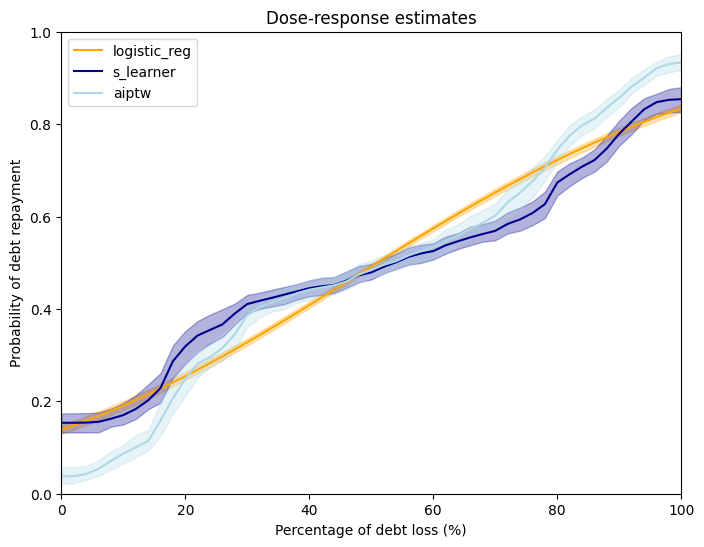

In [39]:
plt.figure(figsize=(8, 6))
for method, results_method in estimates_results.items():
    plt.plot(
        bin_edges,
        results_method["dose-response"]["average"],
        label=method,
        color=colors[method],
    )
    plt.fill_between(
        bin_edges,
        results_method["dose-response"]["lower_bound"],
        results_method["dose-response"]["upper_bound"],
        alpha=0.3,
        color=colors[method],
    )

plt.xlabel("Percentage of debt loss (%)")
plt.ylabel("Probability of debt repayment")
plt.title("Dose-response estimates")
plt.legend()
plt.ylim(0, 1)
plt.xlim(0, 100)
plt.show()